In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [4]:
import sys
sys.path.append('../')

# importing all src code
from src.features import build_features
from src.visualization import visualize
from src.data import make_dataset
from src.reports import make_report

import pandas as pd

In [108]:
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

class single_var:
    '''
    Visualizations that incorporate only one variable
    
    Parameters:
    - study: string specifying the study name
    '''

    def __init__(self, study):
        # figure type - for naming when saving
        self.fig_type = ''
        # study - for naming when saving
        self.study = study

    def timeseries(self, t, y, save=False, **kwargs):
        '''
        Plots a time series of the data
        
        Parameters:
        - t: list of points in time - assumed to be datetime
        - y: list of dependent values - length must be that of t
        - save: whether or not to save the figure, default is False
        
        Possible (other) Parameters:
        - figsize: tuple specifying the size of the figure - default is (16,8)
        - ylabel (or label): string specifying the ylabel - default is None
        - ylim: tuple specifying the y-axis limits - default is [min(y),max(y)]
        - yticks: list specifying the yticks to use - dfault is determined by matplotlib
        
        Returns:
        - fig: the figure handle
        - ax: the axis handle
        '''
        self.fig_type = 'timeseries'

        # setting up figure
        if 'figsize' in kwargs.keys():
            fig, ax = plt.subplots(figsize=kwargs['figsize'])
        else:
            fig, ax = plt.subplots(figsize=(16,8))

        # plotting data
        ax.plot(t,y,linewidth=2,color='black')
        
        # Setting label
        ## x - should never be specified and will remain blank since date formats are obvious (imo)
        ax.set_xlabel('')
        ## y 
        if 'ylabel' or 'label' in kwargs.keys():
            try:
                ax.set_ylabel(kwargs['ylabel'])
            except:
                ax.set_ylabel(kwargs['label'])
        else:
            ax.set_ylabel('')
        
        # Setting limits
        ## x - should never be specified
        ax.set_xlim([t[0],t[-1]])
        ## y
        if 'ylim' in kwargs.keys():
            ax.set_ylim(kwargs['ylim'])
        else:
            ax.set_ylim([np.nanmin(y),np.nanmax(y)])
            
        # Setting ticks
        ## x - should never be specified
        ## xticks are determined based on the number of days included in t - breakpoints are shown below:
        ##  - dt(t) < 2 days - hourly (48 ticks)
        ##  - dt(t) < 7 weeks - daily (49 ticks)
        ##  - dt(t) < 1 year - weekly (52 ticks)
        ##  - dt(t) < 4 years - monthly (48 ticks)
        ##  - dt(t) > 4 years - yearly 
        if t[-1] - t[0] < timedelta(days = 2):
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
            ax.xaxis.set_major_locator(mdates.DayLocator())
            ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
            ax.xaxis.set_minor_locator(mdates.HourLocator())
        elif t[-1] - t[0] < timedelta(days = 49):
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_minor_formatter(mdates.DateFormatter('%a %d'))
            ax.xaxis.set_minor_locator(mdates.DayLocator())
        elif t[-1] - t[0] < timedelta(days = 365):
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
            ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        elif t[-1] - t[0] < timedelta(days = 4*365):
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
        else:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_major_locator(mdates.YearLocator())
            
        plt.xticks(rotation=-45,ha='left')
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=-45, ha='left')
        ## y
        if 'yticks' in kwargs.keys():
            ax.set_yticks(kwargs['yticks'])
        else:
            # default
            pass
            
        # saving figure
        if save:
            # default location for Hagen's projects
            y_var = input('Shorthand for y-variable: ') ## user input for variable to identify figure
            plt.savefig(f'../../reports/figures/{self.study}-{yvar}-{self.fig_type}.pdf')
        
        # return the fig and axis so user can do more unique modifications
        return fig, ax
    
    def heatmap(self, df, col, save=False, **kwargs):
        '''
        Creates a heatmap from the data provided with days as rows and hours as columns
        
        Parameters:
        - df: dataframe indexed by datetime with a column holding the data of interest
        - col: integer or string corresponding to the column of interest in the dataframe
        
        Returns:
        - fig: the figure handle
        - ax: the axis handle
        '''
        
        self.fig_type = 'heatmap'
        # setting up figure
        if 'figsize' in kwargs.keys():
            fig, ax = plt.subplots(figsize=kwargs['figsize'])
        else:
            fig, ax = plt.subplots(figsize=(16,8))
        
        # transforming the dataframe into the correct format
        df_by_hour = df.resample('1h').mean()
        df_by_hour['date'] = df_by_hour.index.date
        df_by_hour['hour'] = df_by_hour.index.hour
        try:
            # if column specified by integer
            df_by_hour_by_var = df_by_hour.iloc[:,[col,-1,-2]]
        except:
            # column specified by name
            df_by_hour_by_var = df_by_hour.loc[:,[col,'date','hour']]
            
        df_transformed = pd.pivot_table(df_by_hour_by_var, values=col, index='date', columns='hour')
        
        # axis ticks
        labels = []
        for d in df_transformed.index:
            labels.append(datetime.strftime(d,'%m/%d'))
            
        # colorbar
        def create_cmap(colors,nodes):
            cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
            return cmap

        # plotting
        if 'colorbar' in kwargs.keys():
            sns.heatmap(df_transformed, yticklabels=labels, vmin=kwargs['colorbar']['ticks'][0], vmax=kwargs['colorbar']['ticks'][-1],
                        cmap=create_cmap(kwargs['colorbar']['colors'],kwargs['colorbar']['ratios']),
                        cbar_kws={'ticks':kwargs['colorbar']['ticks']},
                        ax=ax)
        else:
            sns.heatmap(df_transformed, yticklabels=labels, ax=ax)
        
        # fixing axis labels
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('')
            
        # saving figure
        if save:
            # default location for Hagen's projects
            y_var = input('Shorthand for y-variable: ') ## user input for variable to identify figure
            plt.savefig(f'../../reports/figures/{self.study}-{yvar}-{self.fig_type}.pdf')
        
        # return the fig and axis so user can do more unique modifications
        return fig, ax

## Testing heatmap

In [109]:
plotter = single_var('test')

In [110]:
#df = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col='Timestamp',parse_dates=True)

(<Figure size 864x1152 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f91cc6daf60>)

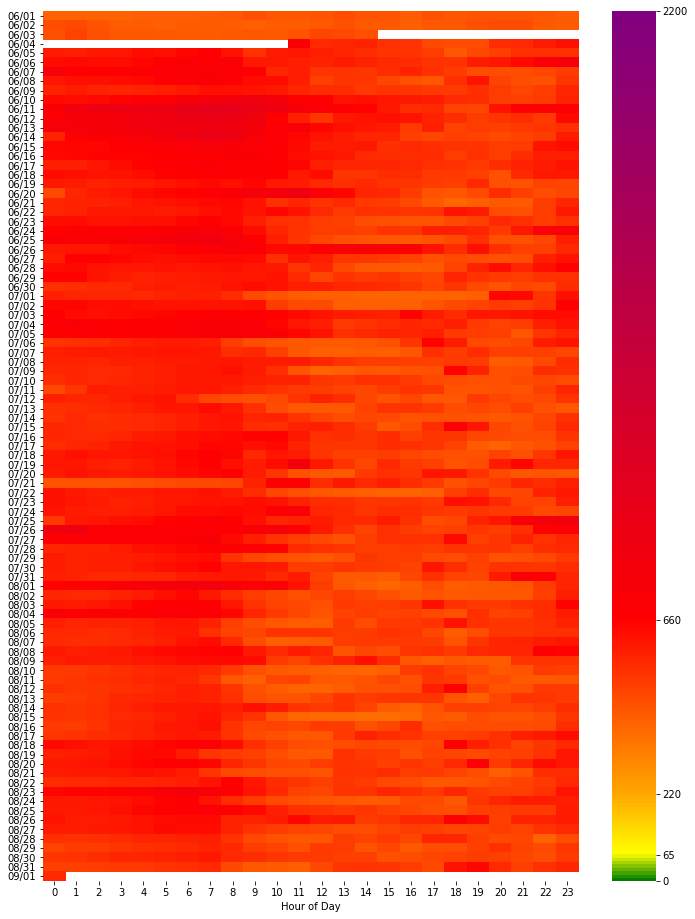

In [112]:
df = df[df['Beacon'] == 25]
df = df[datetime(2020,6,1):datetime(2020,9,1)]
plotter.heatmap(df, 'CO2',figsize=(12,16),
                colorbar={'colors':["green", "yellow", "orange", "red", "purple"],'ratios':[0.0, 0.03, 0.1, 0.3, 1],'ticks':[0,65,220,660,2200]})

In [115]:
plotter = visualize.single_var('test')

(<Figure size 864x1152 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f91c4567c50>)

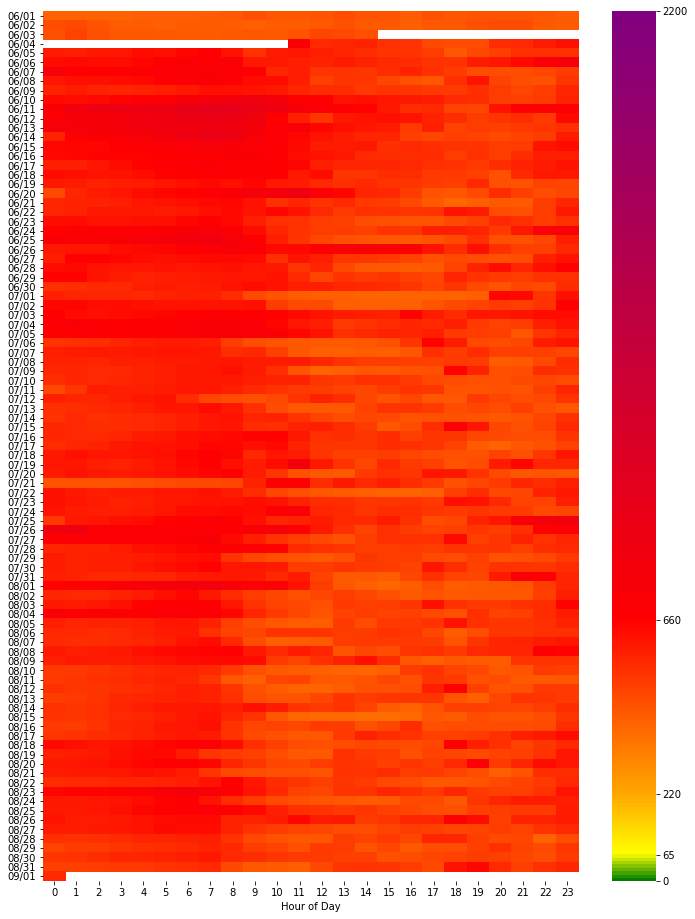

In [116]:
plotter.heatmap(df, 'CO2',figsize=(12,16),
                colorbar={'colors':["green", "yellow", "orange", "red", "purple"],'ratios':[0.0, 0.03, 0.1, 0.3, 1],'ticks':[0,65,220,660,2200]})